# ANN

The notebook is intended to provide the basic tutorial of using popular neural networks;

- Feed forward neural network
- Recurrent neural network
- Convolutional neural network

<br>

All the implementations are done in tensorflow (version 2.3.0)

In [1]:
import math
import pandas as pd
import numpy as np
import random
import os
from tqdm import tqdm

from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# require for installation: !pip install -q git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
print(f'Current TF version: {tf.__version__}')

import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
np.set_printoptions(suppress=True)

SEED = 515

Current TF version: 2.3.0


## Feed forward neural network example

Using FF-NN to predict simple regression problem.

In [2]:
def split_train_test_(X, y, train_frac=0.8):
    _n = X.shape[0]
    train_size = int(_n * train_frac)
    test_size = _n - train_size
    print(f'Generate train data size of {train_size} and test size of {test_size}')
    _idx = list(range(_n))
    random.seed(SEED)
    random.shuffle(_idx)
    X_train, X_test = X[_idx[: train_size]], X[_idx[train_size: ]]
    y_train, y_test = y[_idx[: train_size]], y[_idx[train_size: ]]
    return X_train, X_test, y_train, y_test


def make_regression_(n_samples, n_features, noise, bias, random_state, 
                     coef_ind: bool=True):
    np.random.seed(SEED)
    n_informative = np.random.randint(2, n_features)
    print(f'Random informative features are {n_informative} out of {n_features}')
    coef = None
    if coef_ind:
        X, y, coef = make_regression(n_samples=n_samples, n_features=n_features,
                                     n_informative=n_informative, bias=bias, noise=noise,
                                     random_state=random_state, coef=True)
        print(f'The sample data has been generated using bias of {bias} with coef of {coef}')
    
    else:
        X, y = make_regression(n_samples=n_samples, n_features=n_features,
                               n_informative=n_informative, bias=bias, noise=noise,
                               random_state=random_state, coef=False)
    return X, y, coef


def print_regress_metric(actual, prediction,
                         output_return_bool: bool=False):
    output = dict()
    _r2 = r2_score(actual, prediction)
    _mae = mean_absolute_error(actual, prediction)
    _mse = mean_squared_error(actual, prediction)
    _rmse = math.sqrt(_mse)
    print(f'r2 score = {_r2}\nmae = {_mae}')
    print(f'mse = {_mse}\nrmse = {_rmse}')
    if output_return_bool:
        output['r2'] = _r2
        output['mae'] = _mae
        output['mse'] = _mse
        output['rmse'] = _rmse
        
    return output



In [3]:
X, y, coef = make_regression_(n_samples=10000, n_features=5, noise=12.3, 
                              bias=100, random_state=121, coef_ind=True)

Random informative features are 3 out of 5
The sample data has been generated using bias of 100 with coef of [ 0.         46.52070862  0.         53.71552925 34.014085  ]


In [4]:
X_train, X_test, y_train, y_test = split_train_test_(X, y, train_frac=0.8)

Generate train data size of 8000 and test size of 2000


In [5]:
def build_model(num_input_features: int):
    model = keras.Sequential([
        layers.Dense(16, activation='relu', input_shape=[num_input_features]),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model



In [6]:
EPOCHS = 500

model = build_model(num_input_features=X.shape[1])
print(model.summary())
history = model.fit(
  X_train, y_train,
  epochs=EPOCHS, validation_split=0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________
None

Epoch: 0, loss:15791.8037,  mae:105.9466,  mse:15791.8037,  val_loss:15864.1865,  val_mae:106.0456,  val_mse:15864.1865,  
....................................................................................................
Epoch: 100, loss:161.0989,  mae:10.0697,  mse:161.0989,  val_loss:149.4345,  val_mae:9.6117,  val_mse:149.4345,  
....................................................................................................
Epoch: 200, loss:150.4340,  mae:9.7562,  mse:150.4340,  val_loss:141.0957, 

We can obtain the weights of each neurons in each layer by simply called `get_weights()` method. 
<br>
For each dense layer, it returns a list of two values; per-output weights and the bias value.

In [7]:
model.get_weights()

[array([[-0.10793951,  0.6851899 ,  0.31258664, -0.22946198, -0.10360497,
          0.07920212, -0.03487908, -0.11465095,  0.11988817, -0.10524322,
         -0.7497012 , -0.3201737 ,  0.22216499,  0.0770138 , -0.01989879,
          0.45181972],
        [ 0.6433325 ,  0.7671726 , -4.672992  ,  1.8556503 ,  0.5935214 ,
          0.75599706,  0.7838275 ,  0.6778699 ,  2.8166115 ,  3.3386242 ,
          2.1963527 ,  0.9516633 ,  1.1861967 ,  0.6827333 ,  0.09116616,
          0.8477216 ],
        [-0.31048554, -0.08343116, -0.82674885,  0.9383596 , -0.2193925 ,
         -0.26552403, -0.22133762, -0.18917382,  0.14383228,  0.5189588 ,
          0.25994763,  0.05517236,  0.26285008, -0.18543752, -0.04816552,
         -0.515052  ],
        [ 0.9519469 ,  1.0753846 , -5.213487  ,  2.605244  ,  0.85650855,
          0.9460116 ,  1.0557476 ,  0.998884  ,  3.3854053 ,  3.0143285 ,
          2.692636  ,  0.9242157 ,  0.6838376 ,  0.96853095,  0.0389341 ,
          0.7982755 ],
        [ 0.58599514

Model performance on each epoch

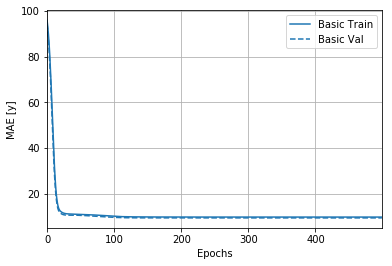

In [8]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plt.figure(figsize=(6, 4))
plotter.plot({'Basic': history}, metric="mae")
plt.ylabel('MAE [y]')
plt.show()

Overall prediction performance

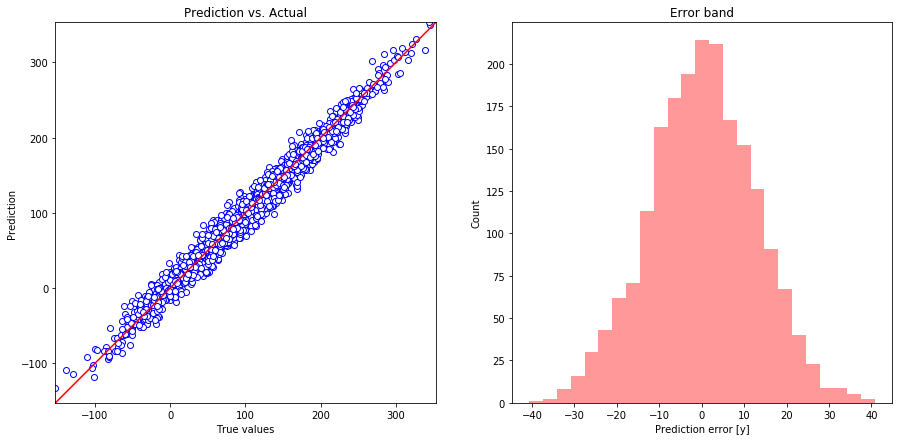

In [9]:
y_pred = model.predict(X_test).flatten()

def visual_actual_pred(y_true, y_pred):
    _err = y_pred - y_true
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 7))
    axes[0].scatter(y_test, y_pred, lw=1, edgecolors='blue', c='white')
    axes[0].set_xlabel('True values')
    axes[0].set_ylabel('Prediction')
    lims = [np.amin([y_true, y_pred]), np.amax([y_true, y_pred])]
    axes[0].set_xlim(lims)
    axes[0].set_ylim(lims)
    axes[0].plot(lims, lims, c='red')
    axes[0].set_title('Prediction vs. Actual')
    axes[1].hist(_err, bins=25, facecolor='r', alpha=0.4)
    axes[1].set_xlabel('Prediction error [y]')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Error band')
    plt.show()
    return


visual_actual_pred(y_test, y_pred)


## Recurrent Neural Network

This neural network is different from traditional feed forward neural network. This network type has internal storage, which can represent the context information of the input data.

<br>

We will use GOOGL stock data to demonstrate how we can implement both GRUs and LSTMs model

In [10]:
df = pd.read_csv('../Data/datasets_8388_11883_GOOGL_2006-01-01_to_2018-01-01.csv', 
                 index_col='Date', parse_dates=['Date'])
display(df.head(3))
print(f'First date: {df.index.min()} and last date: {df.index.max()}')

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL


First date: 2006-01-03 00:00:00 and last date: 2017-12-29 00:00:00


Check for null data

In [11]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

We will use data from 2006 to end of 2016 as training set and 2017 as test set

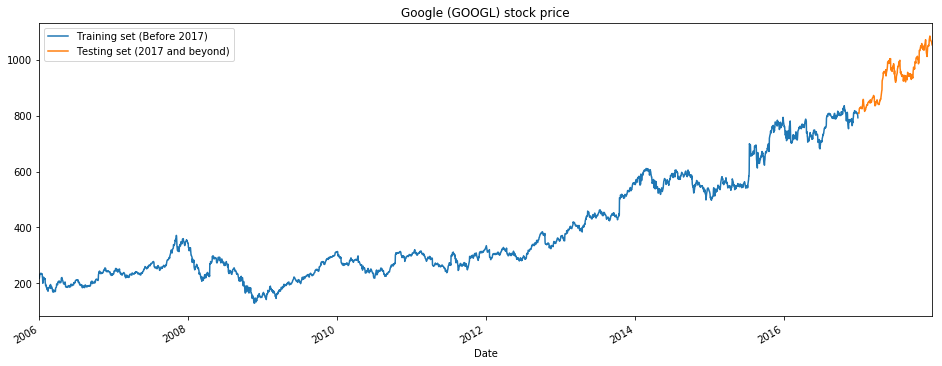

In [12]:
df["Close"][:'2016'].plot(figsize=(16, 6), legend=True)
df["Close"]['2017':].plot(figsize=(16, 6), legend=True)
plt.legend(['Training set (Before 2017)', 'Testing set (2017 and beyond)'])
plt.title('Google (GOOGL) stock price')
plt.show()

We will attempt to predict the closing price of GOOGL stock.

In [13]:
def gen_X_y(n_steps: int, array_: np.ndarray):
    '''Function to generate the X and y according to the specified time step
    '''
    X = []
    y = []
    for i in range(n_steps, len(array_)):
        X.append(array_[(i - n_steps): i, 0])
        y.append(array_[i, 0])
        
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

In [14]:
n_steps = 60

training_set = df[: '2016'].iloc[:, 3: 4].values
testing_set = df['2017': ].iloc[:, 3: 4].values

sc = MinMaxScaler(feature_range=(0, 1))
# sc = StandardScaler()
training_set_transformed = sc.fit_transform(training_set)
X_train, y_train = gen_X_y(n_steps, training_set_transformed)
print(f'Training data shape -- X: {X_train.shape}, y: {y_train.shape}')

test_input = df[(len(df) - len(testing_set) - n_steps): ].iloc[:, 3: 4].values
test_input = test_input.reshape(-1, 1)
test_input = sc.transform(test_input)
X_test, y_test = gen_X_y(n_steps=n_steps, array_=test_input)
print(f'Testing data shape -- X: {X_test.shape}, y: {y_test.shape}')
y_test = y_test.reshape(-1, 1)
y_test = sc.inverse_transform(y_test)

Training data shape -- X: (2708, 60, 1), y: (2708,)
Testing data shape -- X: (251, 60, 1), y: (251,)


### GRUs (Gated Recurrent Units)

In simple words, the GRU unit does not have to use a memory unit to control the flow of information like the LSTM unit. It can directly makes use of the all hidden states without any control. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize. But, with large data, the LSTMs with higher expressiveness may lead to better results.

<br> 

The input layer will be (batch, time, features). Because we only use one 1 feature here so it has been hardcoded to 1 in the code (both GRUs and LSTMs).

In [15]:
gru_model = keras.Sequential([
    layers.GRU(32, return_sequences=True, input_shape=(n_steps, 1), activation='tanh'),
    layers.GRU(32, return_sequences=True, activation='tanh'),
    layers.Dropout(0.2),
    layers.GRU(32, return_sequences=True, activation='tanh'),
    layers.GRU(32, return_sequences=False, activation='tanh'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

gru_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.losses.MeanSquaredError(), metrics=['mae', 'mse'])
print(gru_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 60, 32)            3360      
_________________________________________________________________
gru_1 (GRU)                  (None, 60, 32)            6336      
_________________________________________________________________
dropout (Dropout)            (None, 60, 32)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 60, 32)            6336      
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=50,
                                                  mode='min')
gru_hist = gru_model.fit(
    X_train, y_train, epochs=500, validation_split=0.2,
    batch_size=32, verbose=0,
    callbacks=[tfdocs.modeling.EpochDots(), early_stopping]
)


Epoch: 0, loss:0.0110,  mae:0.0620,  mse:0.0110,  val_loss:0.0018,  val_mae:0.0336,  val_mse:0.0018,  
....................................................................................................
Epoch: 100, loss:0.0004,  mae:0.0134,  mse:0.0004,  val_loss:0.0014,  val_mae:0.0313,  val_mse:0.0014,  
........

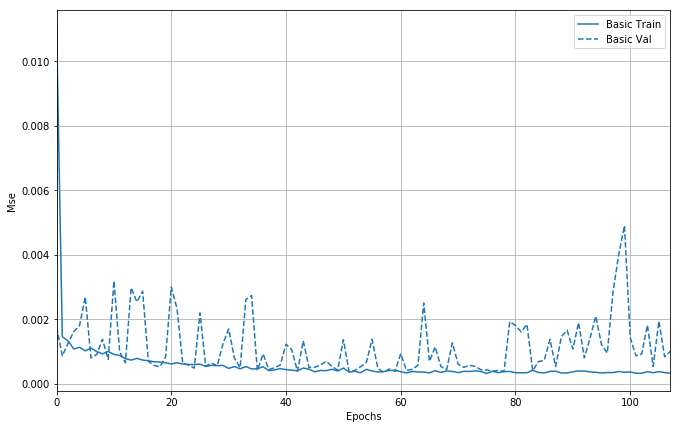

In [17]:
plt.figure(figsize=(11, 7))
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({'Basic': gru_hist}, metric='mse')
plt.show()

In [18]:
y_pred_gru = gru_model.predict(X_test)
y_pred_gru = sc.inverse_transform(y_pred_gru)

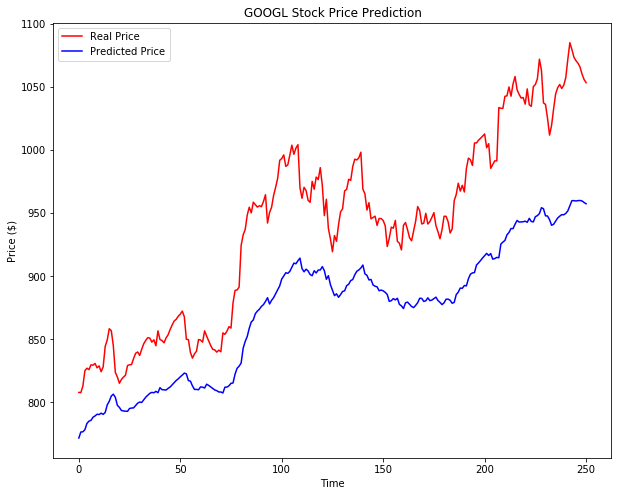

In [19]:
plt.figure(figsize=(10, 8))
plt.plot(y_test, color='red',label='Real Price')
plt.plot(y_pred_gru, color='blue',label='Predicted Price')
plt.title('GOOGL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [20]:
_ = print_regress_metric(y_test, y_pred_gru)

r2 score = 0.08711351599971662
mae = 66.99316116393801
mse = 5164.797039669123
rmse = 71.86652238468982


### LSTMs

Actually, LSTM shares many of the properties of the Gated Recurrent Unit (GRU). But the design is slightly more complex than GRU.

<br>

It is inspired by logic gates of a computer. One gate is needed to read out the entries from the cell, __output gate__. A second gate is needed to decide when to read data into the cell, __input gate__. And a mechanism to reset the contents of the cell, which is governed by a __forget gate__. This is done to be able to decide when to remember and when to ignore the inputs in the latent state.

In [21]:
lstm_model = tf.keras.Sequential([
    layers.LSTM(32, return_sequences=True, input_shape=(n_steps, 1)),
    layers.LSTM(32, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(32, return_sequences=True),
    layers.LSTM(32),
    layers.Dropout(0.2),
    layers.Dense(1)
])

lstm_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.losses.MeanSquaredError(),
                  metrics=['mae', 'mse'])

print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 32)            4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 32)            8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 32)            8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=60,
                                                  mode='min')

lstm_hist = lstm_model.fit(
    X_train, y_train, epochs=500, validation_split=0.2,
    batch_size=32, verbose=0,
    callbacks=[tfdocs.modeling.EpochDots(), early_stopping]
)


Epoch: 0, loss:0.0122,  mae:0.0709,  mse:0.0122,  val_loss:0.0031,  val_mae:0.0416,  val_mse:0.0031,  
....................................................................................................
Epoch: 100, loss:0.0003,  mae:0.0128,  mse:0.0003,  val_loss:0.0024,  val_mae:0.0407,  val_mse:0.0024,  
...........................................

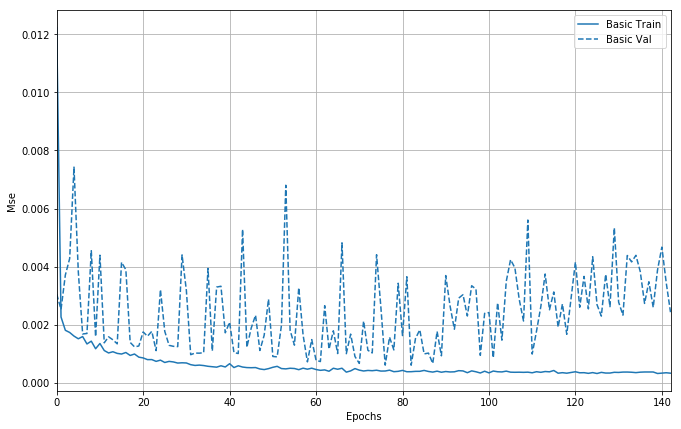

In [23]:
plt.figure(figsize=(11, 7))
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({'Basic': lstm_hist}, metric='mse')
plt.show()

In [24]:
y_pred_lstm = lstm_model.predict(X_test)
y_pred_lstm = sc.inverse_transform(y_pred_lstm)

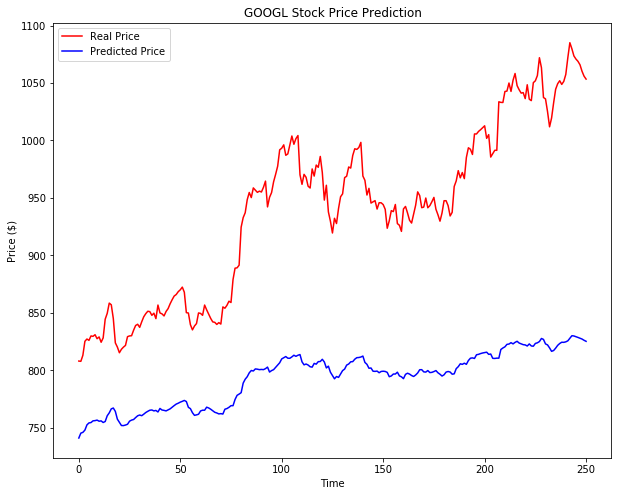

In [25]:
plt.figure(figsize=(10, 8))
plt.plot(y_test, color='red',label='Real Price')
plt.plot(y_pred_lstm, color='blue',label='Predicted Price')
plt.title('GOOGL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [26]:
_ = print_regress_metric(y_test, y_pred_lstm)

r2 score = -3.267761883252609
mae = 146.32203463489793
mse = 24145.52556857546
rmse = 155.38830576518768


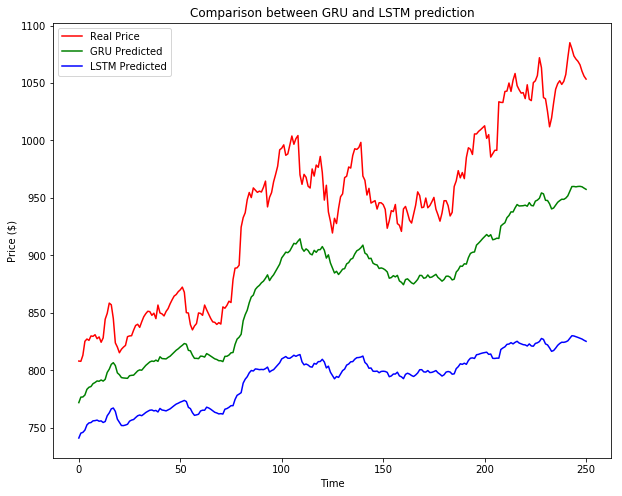

In [27]:
plt.figure(figsize=(10, 8))
plt.plot(y_test, color='red', label='Real Price')
plt.plot(y_pred_gru, color='green', label='GRU Predicted')
plt.plot(y_pred_lstm, color='blue', label='LSTM Predicted')
plt.title('Comparison between GRU and LSTM prediction')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

## Convolutional Neural Network

This data was initially published on https://datahack.analyticsvidhya.com by Intel to host a Image classification Challenge.

<br>

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.

- The image consists of six classes
- Train and test folders have their designated class output while prediction folder does not consist of label (this is used for hackaton scoring).
- The image size is 150x150.

<br>

The class labels are 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street.

Let's set up some parameters for this task.

In [28]:
os.listdir('../data/image/seg_train/seg_train/')

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [29]:
img_class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
img_class_label = {_class: idx for idx, _class in enumerate(img_class_names)}
print(img_class_label)
N_CLASS = len(img_class_label)
IMG_SIZE = (150, 150) 
TRAIN_DIR = '../data/image/seg_train/seg_train/'
TEST_DIR = '../data/image/seg_test/seg_test/'

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


Let's load and visualize some of the images.

In [30]:
def load_img(train_path: str, test_path: str):
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    datasets = [train_path, test_path]
    output = []
    # Iterate through training and test sets
    for data_ in datasets:
        imgs = []
        labels = []
        print(f'Loading: {data_}')
        for folder in os.listdir(data_):
            label = img_class_label[folder]
            for file in tqdm(os.listdir(os.path.join(data_, folder))):
                img_path = os.path.join(os.path.join(data_, folder), file)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, IMG_SIZE)
                imgs.append(img)
                labels.append(label)
                
        imgs = np.array(imgs, dtype='int32')
        labels = np.array(labels, dtype='int32')   
        output.append((imgs, labels))
        
    return output

In [31]:
(train_imgs, train_labels), (test_imgs, test_labels) = load_img(TRAIN_DIR, TEST_DIR)

Loading: ../data/image/seg_train/seg_train/


100%|█████████████████████████████████████████████████████████████████████████████| 2382/2382 [00:03<00:00, 600.32it/s]


Loading: ../data/image/seg_test/seg_test/


100%|███████████████████████████████████████████████████████████████████████████████| 501/501 [00:00<00:00, 600.30it/s]


Shuffle and rescale the data

In [32]:
train_imgs, train_labels = shuffle(train_imgs, train_labels, random_state=SEED)
train_imgs = train_imgs / 255.0
test_imgs = test_imgs / 255.0

### Data checking

In [33]:
print(f'# of training images: {train_imgs.shape[0]} with size of {train_imgs.shape[1: 3]}')
print(f'# of testing images: {test_imgs.shape[0]} with size of {test_imgs.shape[1: 3]}')

# of training images: 14034 with size of (150, 150)
# of testing images: 3000 with size of (150, 150)


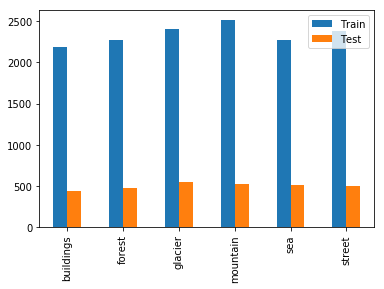

In [34]:
_, train_cnts = np.unique(train_labels, return_counts=True)
_, test_cnts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'Train': train_cnts,
              'Test': test_cnts},
             index=img_class_names
            ).plot.bar()
plt.show()

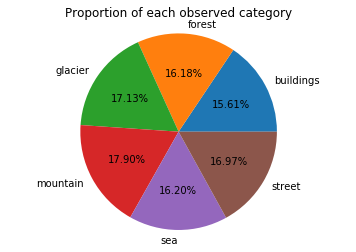

In [35]:
plt.pie(train_cnts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=img_class_names,
        autopct='%1.2f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

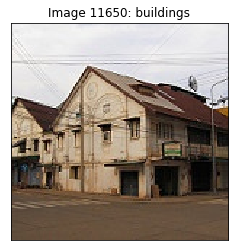

In [36]:
_idx = np.random.randint(train_imgs.shape[0])
plt.figure()
plt.imshow(train_imgs[_idx])
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.title(f'Image {_idx}: {img_class_names[train_labels[_idx]]}')
plt.show()

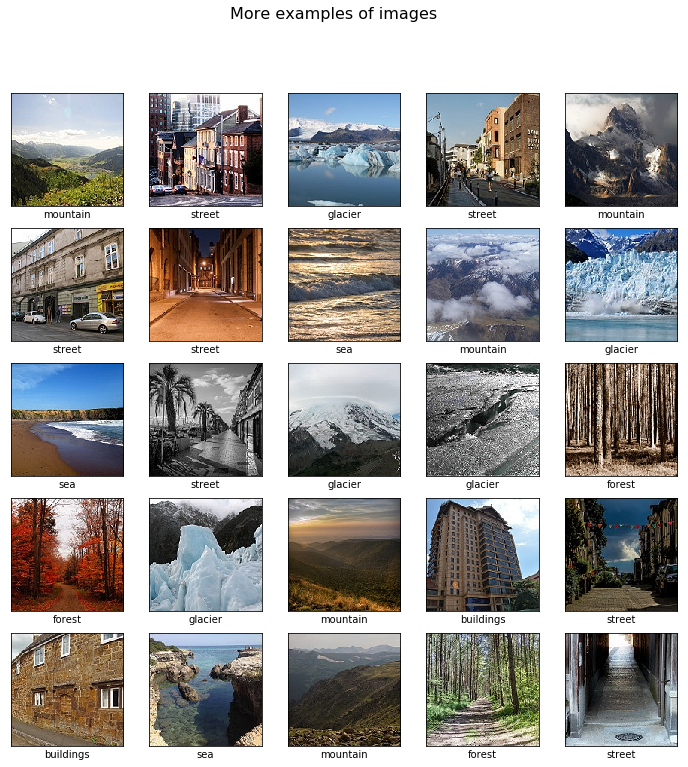

In [37]:
fig = plt.figure(figsize=(12, 12))
fig.suptitle('More examples of images', fontsize=16)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_imgs[i])
    plt.xlabel(img_class_names[train_labels[i]])
    
plt.show()

### Basic CNN model

Let's build a quick CNN model

- Conv2D: (32 filters of size 3 by 3) The features will be "extracted" from the image.
- MaxPooling2D: The images get half sized.
- Flatten: Transforms the format of the images from a 2d-array to a 1d-array of 150 150 3 pixel values.

We use softmax in the output layer to get the probabilities to which class the image belongs to



In [38]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=train_imgs.shape[1: 4]), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(N_CLASS, activation=tf.nn.softmax)
])

cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9248)             

In [39]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')
cnn_hist = cnn_model.fit(
    train_imgs, train_labels, epochs=500, validation_split=0.2, verbose=0,
    batch_size=64, callbacks=[tfdocs.modeling.EpochDots(), early_stopping]
)


Epoch: 0, accuracy:0.5945,  loss:1.0529,  val_accuracy:0.6815,  val_loss:0.8573,  
...............

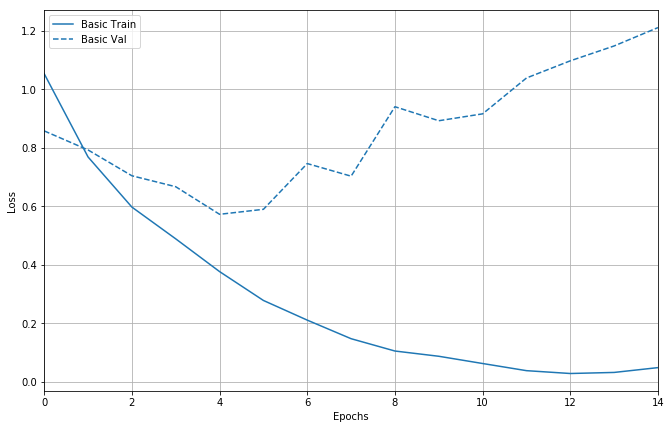

In [40]:
plt.figure(figsize=(11, 7))
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({'Basic': cnn_hist}, metric='loss')
plt.show()

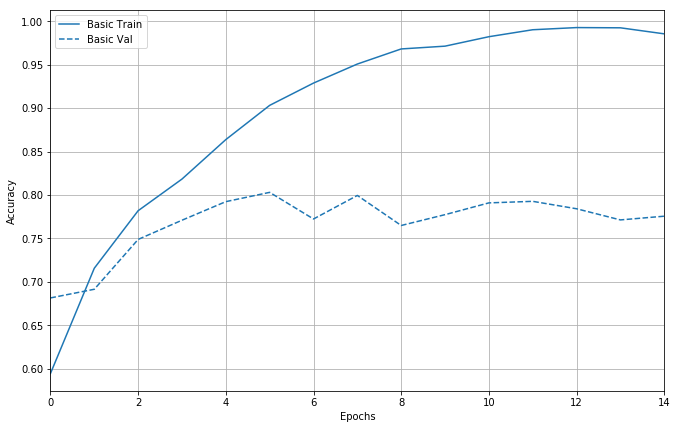

In [41]:
plt.figure(figsize=(11, 7))
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({'Basic': cnn_hist}, metric='accuracy')
plt.show()

We can see that we are overfitting the training image a bit, comparing the performance against the validation set.

Train vs. test performance (loss, accuracy)

In [44]:
cnn_model.evaluate(train_imgs, train_labels, verbose=0)

[0.2702607214450836, 0.9471996426582336]

In [54]:
cnn_model.evaluate(test_imgs, test_labels, verbose=0)

[1.3209165334701538, 0.7603333592414856]

### CNN with data augmentation

The above method is considering to be one-way street of solving computer vision task (especially image classification).

To help the model to classify image better, we will use image augmentation to generate more images for each class to fit the model.

<br>

In this section, I will implement the general approach for feeding and building the image classification model.

In [45]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=40, shear_range=0.2,
                                                            zoom_range=0.2, horizontal_flip=True,
                                                            vertical_flip=True, rescale=1./255.,
                                                            validation_split=0.2
                                                           )

train_generator = train_gen.flow_from_directory(TRAIN_DIR, target_size=IMG_SIZE, 
                                                batch_size=32, class_mode='categorical',
                                                subset='training')

valid_generator = train_gen.flow_from_directory(TRAIN_DIR, target_size=IMG_SIZE,
                                                batch_size=32, class_mode='categorical',
                                                subset='validation')


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [46]:
cnn_model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(N_CLASS, activation=tf.nn.softmax)
])

cnn_model2.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=tf.losses.CategoricalCrossentropy(),
                   metrics=['accuracy'])

cnn_model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9248)             

In [47]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')

cnn_hist2 = cnn_model2.fit_generator(
    train_generator,
    validation_data=valid_generator,
    epochs=500, 
    callbacks=[tfdocs.modeling.EpochDots(), early_stopping],
    verbose=0
)

W0824 23:02:35.145712 26568 deprecation.py:323] From <ipython-input-47-d26a020c552b>:8: Model.fit_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.fit, which supports generators.



Epoch: 0, accuracy:0.5194,  loss:1.1866,  val_accuracy:0.6049,  val_loss:1.0272,  
............................

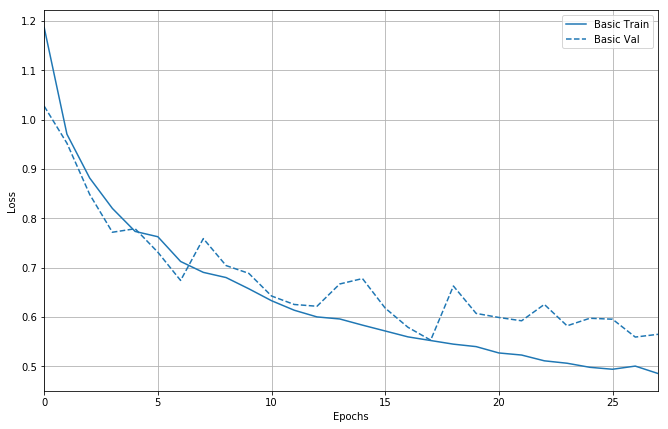

In [48]:
plt.figure(figsize=(11, 7))
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({'Basic': cnn_hist2}, metric='loss')
plt.show()

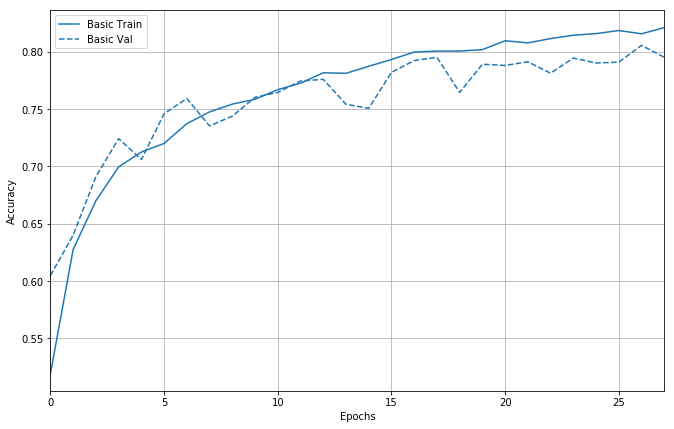

In [49]:
plt.figure(figsize=(11, 7))
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({'Basic': cnn_hist2}, metric='accuracy')
plt.show()

Let's use the model to predict the test images

In [50]:
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)
test_generator = test_gen.flow_from_directory(TEST_DIR, target_size=IMG_SIZE,
                                              batch_size=64, class_mode='categorical')
pred = cnn_model2.predict(test_generator)

Found 3000 images belonging to 6 classes.


Train vs. test performance of the model (loss, accuracy)

In [51]:
cnn_model2.evaluate(train_generator, verbose=0)

[0.47106143832206726, 0.8301870226860046]

In [52]:
cnn_model2.evaluate(test_generator, verbose=0)

[0.5243974328041077, 0.8096666932106018]

W0825 00:17:18.020099 26568 deprecation.py:323] From <ipython-input-53-b2f517bfe660>:10: Sequential.predict_classes (from tensorflow.python.keras.engine.sequential) is deprecated and will be removed after 2021-01-01.
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


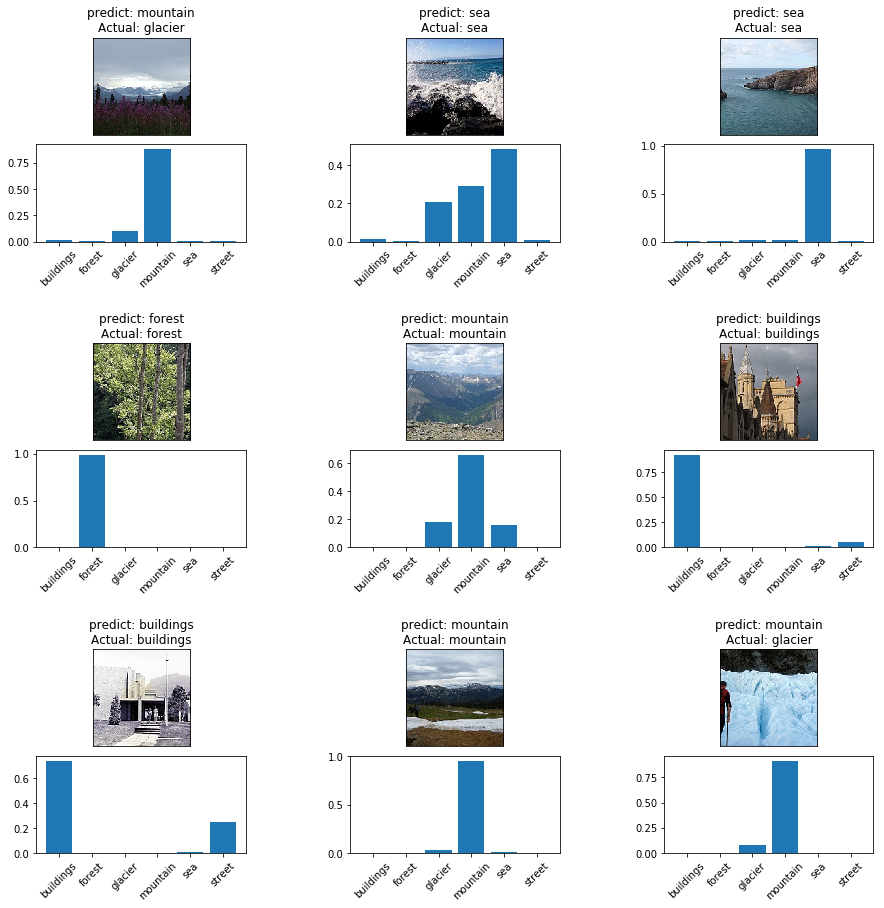

In [53]:
fig = plt.figure(figsize=(15, 15))
outer = gridspec.GridSpec(3, 3, wspace=0.5, hspace=0.5)

for i in range(9):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[i], 
                                             wspace=0.1, hspace=0.1)
    rnd_num = np.random.randint(0, len(test_imgs))
    pred_img = np.array([test_imgs[rnd_num]])
    actual_ = img_class_names[test_labels[rnd_num]]
    pred_class = img_class_names[cnn_model2.predict_classes(pred_img)[0]]
    pred_prob = cnn_model2.predict(pred_img).reshape(6)
    for j in range(2):
        if (j % 2) == 0:
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(pred_img[0])
            ax.set_title(f'predict: {pred_class}\nActual: {actual_}')
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
            
        else:
            ax = plt.Subplot(fig, inner[j])
            ax.bar(img_class_names, pred_prob)
            ax.tick_params(axis='x', labelrotation=45)
            fig.add_subplot(ax)


plt.show()